## Singleton Fraction

Consider all windows of a fixed size  containing $m$ ALT alleles
(c.f., [here](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb)). 
Let $\hat{p}(m)$ denote the Maximum Likelihood Estimate of the 
probability that a randomly chosen ALT allele is a singleton 
(appearing in just one chromosome). Then, 
under a variety of assumptions (e.g., ALT allele frequencies are independent), 
we have

$$ 
\hat{p}(m) = \frac{\sum_{k=0}^{m} k w_k}{ m\, \sum_{k=0}^{m} w_k} 
$$

where $w_k$ is the number of windows in which $k$ of the $m$ ALT alleles are singletons. 



skipping: singleton_count_mean = 0.0, snv_count = 0


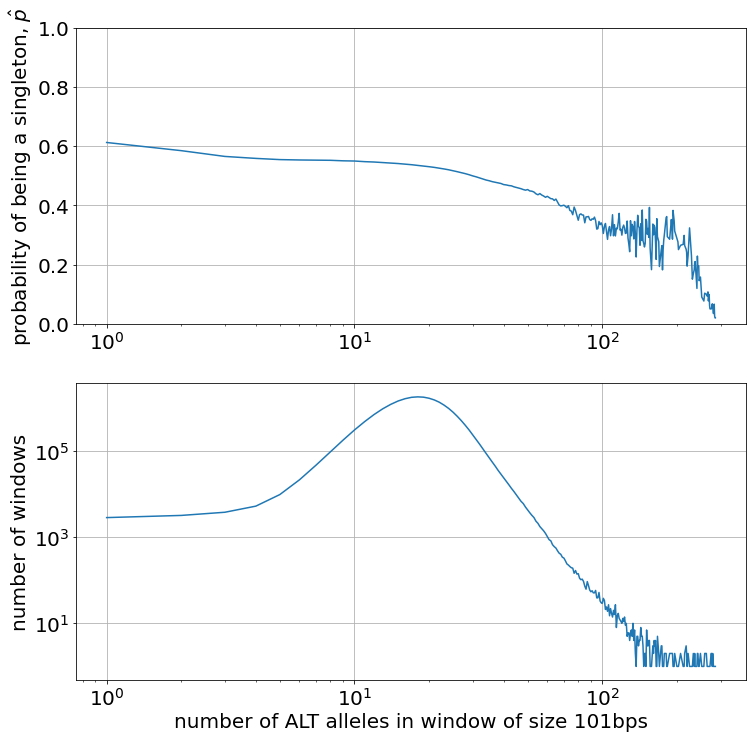

In [1]:
import numpy as np 
np.seterr(all='raise')

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})

from read_model import read_model 
model = read_model('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json')

def compute_phat(snv_count, window_counts): 
  singleton_counts = np.arange(0, snv_count+1)
  # https://stackoverflow.com/a/50786849/6674256
  singleton_count_mean, window_count = np.average(singleton_counts, weights=window_counts, returned=True)
  try:
    p_hat = singleton_count_mean/snv_count
    return p_hat, window_count
  except FloatingPointError: 
    print(
      f'skipping: '
      f'singleton_count_mean = {singleton_count_mean}, '
      f'snv_count = {snv_count}'
    )
    return None, None

def plot_phat(): 
  xs, ys1, ys2 = [], [], []
  for snv_count, window_counts in model['singletonCounts'].items(): 
    p_hat, window_count = compute_phat(snv_count, window_counts)
    xs.append(snv_count)
    ys1.append(p_hat)
    ys2.append(window_count)

  xs, ys1, ys2 = map(np.array, zip(*sorted(zip(xs, ys1, ys2), key=lambda triplet: triplet[0])))

  fig = plt.figure()
  fig.set_size_inches(12, 12)  
  axis1 = plt.subplot(2, 1, 1)
  axis2 = plt.subplot(2, 1, 2, sharex=axis1)
  axis1.plot(xs, ys1)
  axis1.set_xscale('log')
  axis1.set_ylim([0, 1])
  axis1.set_ylabel('probability of being a singleton, $\hat{p}$')
  axis1.grid()
  axis2.plot(xs, ys2)
  axis2.set_yscale('log')
  axis2.set_xlabel(f"number of ALT alleles in window of size {model['windowSize']}bps")
  axis2.set_ylabel('number of windows')
  axis2.grid()

plot_phat()

The first graph shows that $\hat{p}(m)$ depends on $m$. (The second graph shows that $\hat{p}(m)$ is a robust estimate.) This is not what is expected under a [simple neutral population-genetics model](https://en.wikipedia.org/wiki/Allele_frequency_spectrum#Calculation), where the expected fraction of SNPs that are singletons is

$$ 
\frac{x_1^{(m)}}{\sum_{i=1}^{n-1} x_i^{(m)}} = \frac{\theta^{(m)}}{\sum_{i=1}^{n-1} \theta^{(m)} / i }
 = \frac{1}{\sum_{i=1}^{n-1} 1 / i } ,
$$

which is independent of the ALT-allele count, $m$. Here $x_i$ is the expected number of ALT alleles that segregate in $i$ individuals from a sample of $n$ chromosomes, and $\theta^{(m)}$ is the population scaled mutation rate that would yield, on average, 
$m$ ALT alleles in a window of the given size. 






I do not know whether including demography and/or linkage disequilibirum in such a neutral model could yield the observed dependence of singleton fraction, $\hat{p}$, on ALT-allele count, $m$. However, it is interesting to note that the singleton fraction, $\hat{p}$, is "large" when the number of ALT alleles is very low, which is consistent with negative selection (assuming that those low ALT-allele counts cannot be explained by sequence context). Indeed, a similar correlation has been [reported by the DECODE group](https://www.biorxiv.org/content/10.1101/2021.11.16.468246v1). Conversely, $\hat{p}$, is low in windows containing large number of ALT alleles, which would indicate positive selection, under the same assumptions. In either case, we will not know for sure until we use `constraint-tools` to account for sequence context. 


## Distribution of singleton counts 

The distribution of singleton counts is well-described by the (expected) binomial distribution: 

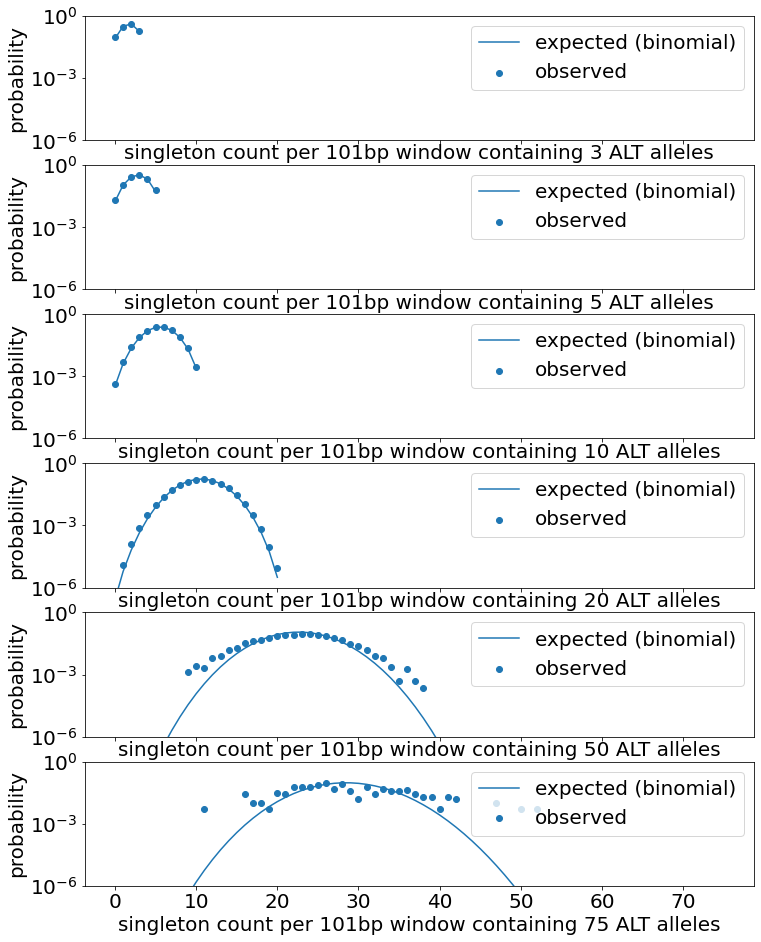

In [2]:
from scipy import stats 

def plot_singleton_count_distribution():
  snv_count_to_xs_ys = {
    3: None, 
    5: None, 
    10: None, 
    20: None, 
    50: None,
    75: None
  }
  for snv_count, window_probabilities in model['singletonProbabilities'].items(): 
    if snv_count not in snv_count_to_xs_ys.keys(): continue 
    singleton_counts = np.arange(0, snv_count+1)
    snv_count_to_xs_ys[snv_count] = (singleton_counts, window_probabilities)
  number_rows = len(snv_count_to_xs_ys)
  fig, axes = plt.subplots(nrows=number_rows, sharex=True)
  fig.set_size_inches(12, 16)  
  for i, snv_count in enumerate(sorted(snv_count_to_xs_ys.keys())):
    xs, ys = snv_count_to_xs_ys[snv_count]
    axes[i].scatter(xs, ys, label='observed')
    axes[i].set_ylabel('probability')
    axes[i].set_xlabel(f"singleton count per {model['windowSize']}bp window containing {snv_count} ALT alleles")

    window_counts = model['singletonCounts'][snv_count]
    p_hat, window_count = compute_phat(snv_count, window_counts)
    ys_expected = stats.binom(snv_count, p_hat).pmf(xs)
    axes[i].plot(xs, ys_expected, label='expected (binomial)')
    axes[i].legend()

    axes[i].set_ylim([1e-6, 1])
    axes[i].set_yscale('log')
    axes[i].set_xscale('linear')
    
plot_singleton_count_distribution()

The plots above show that the observed distribution gets slightly wider relative to the binomial as the number of ALT alleles in the window increases. The following plots confirm this: 

skipping: singleton_count_mean = 0.0, snv_count = 0


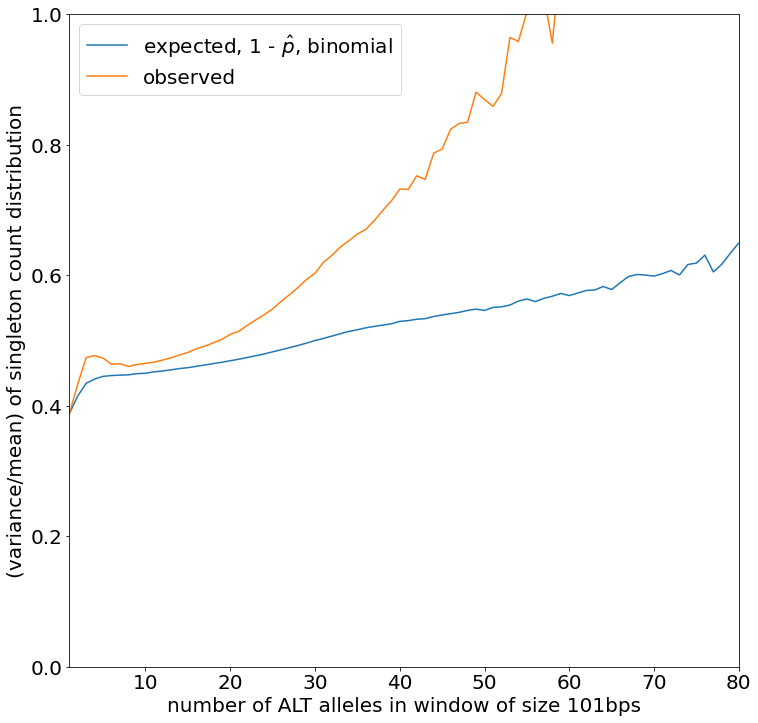

In [3]:
def compute_mean_variance(snv_count, window_counts): 
  singleton_counts = np.arange(0, snv_count+1)
  # https://stackoverflow.com/a/50786849/6674256
  singleton_count_mean = np.average(singleton_counts, weights=window_counts, returned=False)
  singleton_count_variance = np.average((singleton_counts - singleton_count_mean)**2, weights=window_counts, returned=False)
  return singleton_count_mean, singleton_count_variance

def plot_normalized_variance(): 
  xs, ys1, ys2 = [], [], []
  for snv_count, window_counts in model['singletonCounts'].items(): 
    p_hat, _ = compute_phat(snv_count, window_counts)
    mean_observed, variance_observed = compute_mean_variance(snv_count, window_counts)
    if p_hat is not None:
      xs.append(snv_count)
      ys1.append(1 - p_hat)
      ys2.append(variance_observed/mean_observed)

  xs, ys1, ys2 = map(np.array, zip(*sorted(zip(xs, ys1, ys2), key=lambda triplet: triplet[0])))

  fig = plt.figure()
  fig.set_size_inches(12, 12)  
  plt.plot(xs, ys1, label='expected, 1 - $\hat{p}$, binomial')
  plt.plot(xs, ys2, label='observed')
  plt.xscale('linear')
  plt.legend()
  plt.ylim([0, 1])
  plt.xlim([1, 80])
  plt.ylabel('(variance/mean) of singleton count distribution')
  plt.xlabel(f"number of ALT alleles in window of size {model['windowSize']}bps")

plot_normalized_variance()